In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import numpy as np
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.kmedians import kmedians
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric

In [2]:
def shuffle_row(row):
    shuffled_row = row.values.copy()
    np.random.shuffle(shuffled_row)
    return pd.Series(shuffled_row, index=row.index)

def shuffle_rows(df):
    columns_to_shuffle = df.columns[1:]
    df[columns_to_shuffle] = df[columns_to_shuffle].apply(shuffle_row, axis=1)
    return df

In [3]:
def get_geom_mean_expression(expression_df):
    """
    
    Function to take an expression dataframe from the microarrays and collapse it into the means of
    all replicate chips.
    """
    # C2 and S12 got removed during quality control
    x = [
        'Ll', 
        'Lm', 
        'Lh', 
        'S0', 
        'S3', 
        'S6', 
        'S9', 
        # 'S12', 
        'S15', 
        'S24', 
        'C0', 
        # 'C2', 
        'C4', 
        'C6', 
        'C8', 
        'C10', 
        'C12', 
        'C14', 
        'C16', 
        'C18']
    
    # cols = expression_df.columns[1:]
    # x = [c for c in x if c in cols]
    
    condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
    for c in list(expression_df.columns)[1:]:
        
        cond = c.split('_')[0]
        if cond in condition_expr_dict.keys():
            expr_list = condition_expr_dict.get(cond, [])

            # Need to avoid true zeros
            expr_list.append(expression_df[c].values)
            condition_expr_dict[cond] = expr_list
        
    condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
    mean_expr_df = pd.DataFrame(condition_mean_dict)
    mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
    cols = list(mean_expr_df.columns)
    reorder = cols[-1:] + cols[:-1]
    mean_expr_df = mean_expr_df[reorder]
    
    return mean_expr_df

def normalizer(array):
    """
    Normalizes the values of an array to range from zero to one
    """
    
    a = np.array(array)
    
    normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
    return normalized

def normalize_expression_per_gene(expression_df):
    """
    Function to normalize all gene expression to range from zero to one.
    """
    if 'TTHERM_ID' in expression_df.columns:
        ttids = expression_df['TTHERM_ID'].values
        data = expression_df[list(expression_df.columns)[1:]]
        
        norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        norm_expression_df['TTHERM_ID'] = ttids
        
        columns = norm_expression_df.columns.tolist()
        
        rearrangment = columns[-1:] + columns[:-1]
        
        norm_expression_df = norm_expression_df[rearrangment]
        
    else:
        norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
    return norm_expression_df

In [4]:
# Load your gene expression data
gene_data = pd.read_csv('../../active_files/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')  # Assuming the first column is the index

In [5]:
gene_data.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,6.928782,7.264201,6.934214,6.732989,6.970612,7.150978,6.126826,6.868968,6.641119,...,6.450318,8.049750,7.788162,7.052154,6.517742,6.918501,6.048861,7.041619,6.757932,5.817246
1,TTHERM_000000045,9.633489,9.977124,10.027529,9.720665,9.605762,10.225542,10.279608,10.459966,10.693337,...,11.130466,11.207738,11.009172,10.615417,11.038938,11.009222,10.216348,11.099187,11.172276,10.561021
2,TTHERM_00000010,5.066343,4.767264,5.010981,6.139047,4.619361,4.751761,5.818550,5.342529,5.483750,...,6.314438,7.423571,7.507645,7.417087,7.147801,7.747930,7.093641,7.672685,7.511290,6.890117
3,TTHERM_00000020,4.696881,4.638401,4.956299,6.942556,5.101252,4.730307,8.457690,4.526411,4.908300,...,5.250233,4.974993,5.747498,5.252167,5.210531,7.083187,5.252222,5.037613,5.495281,5.013987
4,TTHERM_00000030,4.654278,4.537105,4.928739,5.063991,4.584168,4.911880,5.935311,4.519470,4.757861,...,4.651688,4.920573,4.636333,4.883712,4.779395,4.744335,4.513140,4.838428,4.961475,4.653340


In [6]:
# gene_data = shuffle_rows(gene_data)

In [7]:
gene_data.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,6.928782,7.264201,6.934214,6.732989,6.970612,7.150978,6.126826,6.868968,6.641119,...,6.450318,8.049750,7.788162,7.052154,6.517742,6.918501,6.048861,7.041619,6.757932,5.817246
1,TTHERM_000000045,9.633489,9.977124,10.027529,9.720665,9.605762,10.225542,10.279608,10.459966,10.693337,...,11.130466,11.207738,11.009172,10.615417,11.038938,11.009222,10.216348,11.099187,11.172276,10.561021
2,TTHERM_00000010,5.066343,4.767264,5.010981,6.139047,4.619361,4.751761,5.818550,5.342529,5.483750,...,6.314438,7.423571,7.507645,7.417087,7.147801,7.747930,7.093641,7.672685,7.511290,6.890117
3,TTHERM_00000020,4.696881,4.638401,4.956299,6.942556,5.101252,4.730307,8.457690,4.526411,4.908300,...,5.250233,4.974993,5.747498,5.252167,5.210531,7.083187,5.252222,5.037613,5.495281,5.013987
4,TTHERM_00000030,4.654278,4.537105,4.928739,5.063991,4.584168,4.911880,5.935311,4.519470,4.757861,...,4.651688,4.920573,4.636333,4.883712,4.779395,4.744335,4.513140,4.838428,4.961475,4.653340


In [8]:
gene_data = normalize_expression_per_gene(gene_data)

In [9]:
gene_data.head()

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,0.604560,0.712935,0.606315,0.541298,0.618075,0.676352,0.345444,0.585234,0.511614,...,0.449966,0.966750,0.882229,0.644422,0.471751,0.601238,0.320253,0.641018,0.549357,0.245417
1,TTHERM_000000045,0.015138,0.202748,0.230267,0.062732,0.000000,0.338374,0.367892,0.466359,0.593770,...,0.832424,0.874612,0.766203,0.551230,0.782454,0.766230,0.333354,0.815348,0.855251,0.521531
2,TTHERM_00000010,0.071967,0.023813,0.063054,0.244680,0.000000,0.021317,0.193078,0.116435,0.139173,...,0.272919,0.451498,0.465034,0.450454,0.407097,0.503722,0.398377,0.491607,0.465621,0.365608
3,TTHERM_00000020,0.049259,0.036473,0.105976,0.540233,0.137667,0.056567,0.871488,0.011989,0.095481,...,0.170239,0.110063,0.278956,0.170661,0.161559,0.570979,0.170673,0.123753,0.223814,0.118588
4,TTHERM_00000030,0.027748,0.004712,0.081708,0.108299,0.013964,0.078393,0.279603,0.001245,0.048113,...,0.027239,0.080103,0.024220,0.072855,0.052347,0.045454,0.000000,0.063952,0.088144,0.027564


In [10]:
gene_data

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_000000042,0.604560,0.712935,0.606315,0.541298,0.618075,0.676352,0.345444,0.585234,0.511614,...,0.449966,0.966750,0.882229,0.644422,0.471751,0.601238,0.320253,0.641018,0.549357,0.245417
1,TTHERM_000000045,0.015138,0.202748,0.230267,0.062732,0.000000,0.338374,0.367892,0.466359,0.593770,...,0.832424,0.874612,0.766203,0.551230,0.782454,0.766230,0.333354,0.815348,0.855251,0.521531
2,TTHERM_00000010,0.071967,0.023813,0.063054,0.244680,0.000000,0.021317,0.193078,0.116435,0.139173,...,0.272919,0.451498,0.465034,0.450454,0.407097,0.503722,0.398377,0.491607,0.465621,0.365608
3,TTHERM_00000020,0.049259,0.036473,0.105976,0.540233,0.137667,0.056567,0.871488,0.011989,0.095481,...,0.170239,0.110063,0.278956,0.170661,0.161559,0.570979,0.170673,0.123753,0.223814,0.118588
4,TTHERM_00000030,0.027748,0.004712,0.081708,0.108299,0.013964,0.078393,0.279603,0.001245,0.048113,...,0.027239,0.080103,0.024220,0.072855,0.052347,0.045454,0.000000,0.063952,0.088144,0.027564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20321,TTHERM_02293890,0.178656,0.109809,0.048422,0.071034,0.385238,0.000000,0.716332,0.255116,0.208480,...,0.602522,0.669650,0.629458,0.522463,0.618023,0.542049,0.589131,0.517068,0.699527,0.850138
20322,TTHERM_02385080,0.793598,0.342475,0.834350,0.593193,0.610267,0.721421,0.821797,0.379938,0.763581,...,0.000000,0.894450,0.807465,0.259562,0.786715,0.928782,0.510341,0.977735,0.868325,0.618105
20323,TTHERM_02555200,0.461078,0.000000,0.520474,0.188476,0.200151,0.459836,0.627646,0.520845,0.418029,...,0.317590,0.424080,0.749697,0.418365,0.818543,0.940057,0.642974,0.723721,1.000000,0.831430
20324,TTHERM_02607240,0.646061,0.498276,0.055730,0.281406,0.521778,0.212822,0.924278,0.235940,0.000000,...,0.439230,0.824600,0.847735,0.743985,0.704899,0.777690,0.923941,0.474318,0.394939,1.000000


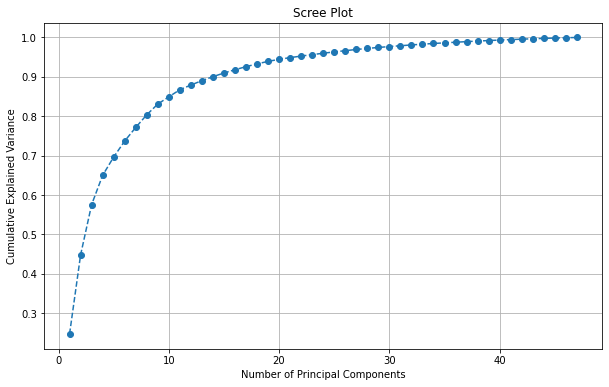

In [11]:
# Assuming df is your DataFrame with the first column as labels
# and the rest of the columns as features
labels = gene_data.iloc[:, 0]
features = gene_data.iloc[:, 1:]

# Apply PCA to the standardized features
pca = PCA()
pca.fit(features)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [12]:
num_components = 15
pca = PCA(n_components=num_components)
pca.fit(features)

# Get the explained variance for the specified number of components
explained_variance = pca.explained_variance_ratio_

# Sum the explained variance to get the total variance explained
total_variance_explained = sum(explained_variance)

# Print the explained variance for each component
print(f"Explained Variance for {num_components} Components: {explained_variance}")
print(f"Total Variance Explained: {total_variance_explained}")

Explained Variance for 15 Components: [0.24747844 0.20054769 0.12770916 0.07443592 0.04631817 0.04068046
 0.03448249 0.032081   0.02716712 0.01850673 0.01788245 0.01201812
 0.01107187 0.01016066 0.00925019]
Total Variance Explained: 0.909790490175282


In [13]:
dict_opt = {'pcs': -1, 'nclusters': -1, 'sscore': -1}

In [14]:

# Extract labels column
labels = gene_data['TTHERM_ID']  # Replace 'labels' with the actual column name

# Drop labels column before PCA
gene_data = gene_data.drop('TTHERM_ID', axis=1)

manhattan_distance_matrix = pairwise_distances(gene_data, metric='manhattan', n_jobs=-1)

# nums_components = np.arange(2,20,1)
nums_components = np.arange(9,31,3)

nums_clusters = np.arange(50,300,25)

for num_components in nums_components:

    # Perform PCA without standardization
    pca = PCA(n_components=num_components)
    principal_components = pca.fit_transform(gene_data)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{num}' for num in range(1, num_components + 1)])

    for num_clusters in nums_clusters:

        initial_centers = kmeans_plusplus_initializer(np.array(pca_df), num_clusters).initialize()
        # create metric that will be used for clustering
        manhattan_metric = distance_metric(type_metric.MANHATTAN)
        # create instance of K-Means using specific distance metric:
        kmedians_instance = kmedians(np.array(pca_df), initial_centers, metric=manhattan_metric)
        # run cluster analysis and obtain results
        kmedians_instance.process()
        clusters = kmedians_instance.get_clusters()

        cluster_assignments = np.zeros(pca_df.shape[0])

        for idx, cluster in enumerate(clusters):
            for gene_idx in cluster:
                cluster_assignments[gene_idx] = idx

        # # Perform K-means clustering
        # kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        # cluster_assignments = kmeans.fit_predict(pca_df)

        # Compute silhouette score
        silhouette_avg = silhouette_score(manhattan_distance_matrix, cluster_assignments, metric='precomputed')
        print(f"Silhouette Score for {num_components} PCs and {num_clusters} clusters: {silhouette_avg}")

        if dict_opt['sscore'] < silhouette_avg:
            dict_opt['sscore'] = silhouette_avg
            dict_opt['nclusters'] = num_clusters
            dict_opt['pcs'] = num_components

Silhouette Score for 9 PCs and 50 clusters: 0.027037728415444755
Silhouette Score for 9 PCs and 75 clusters: 0.025384580517578543
Silhouette Score for 9 PCs and 100 clusters: 0.021402726321388156
Silhouette Score for 9 PCs and 125 clusters: 0.014472546008266413
Silhouette Score for 9 PCs and 150 clusters: 0.011635893690518814
Silhouette Score for 9 PCs and 175 clusters: 0.010737767732579674
Silhouette Score for 9 PCs and 200 clusters: 0.00955214253710708
Silhouette Score for 9 PCs and 225 clusters: 0.011357374033293307
Silhouette Score for 9 PCs and 250 clusters: 0.0051915341088361495
Silhouette Score for 9 PCs and 275 clusters: 0.004068845002981988
Silhouette Score for 12 PCs and 50 clusters: 0.02314448923533238
Silhouette Score for 12 PCs and 75 clusters: 0.015253393946378683
Silhouette Score for 12 PCs and 100 clusters: 0.015700000271798912
Silhouette Score for 12 PCs and 125 clusters: 0.012121528448263853
Silhouette Score for 12 PCs and 150 clusters: 0.012041120430849253
Silhouette

In [15]:
dict_opt

{'pcs': 9, 'nclusters': 50, 'sscore': 0.027037728415444755}